# MOVIE RECOMMENDATION SYSTEM

BY:
    

## Overview

Developing a movie recommendation system to improve the user experience in the entertainment industry. By leveraging historical data , our project aims to enhance customer satisfaction by providing personalized movie suggestions, fostering engagement, and driving user retention

##  Business Understanding</small>

### Background
In this project, our objective is to develop a movie recommendation system utilizing the MovieLens dataset sourced from the GroupLens research lab at the University of Minnesota. This dataset contains user ratings for movies and is widely recognized in academic research and machine learning experiments.

### Business Problem
The primary goal is to enhance the user experience by providing personalized movie recommendations. The system will suggest the top 5 movies to each user based on their previous ratings. This tailored recommendation system aims to boost user engagement, satisfaction, and overall retention within a movie-streaming platform.

### User Interaction
Users will interact with the system through the movie-streaming platform, providing feedback through explicit ratings or indicating preferences through likes, dislikes, or their viewing history. The system's design should seamlessly integrate into the platform's user interface, ensuring a smooth and enjoyable user experience.

### Collaborative Filtering
The recommendation system will heavily rely on collaborative filtering as its primary mechanism. This technique involves making predictions about a user's preferences by aggregating insights from numerous users. Additionally, we may explore a hybrid approach, incorporating content-based filtering to tackle the cold start problem – a scenario where new or unrated movies necessitate recommendations.

### Evaluation Metrics
To gauge the effectiveness of our recommendation system, we will employ pertinent metrics. Traditional regression metrics like Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) will be utilized to quantify the accuracy of predictions. These metrics offer valuable insights into the system's proficiency in forecasting user preferences, guiding us in refining its performance.

**PROBLEM STATEMENT**

With so many movie alternatives available nowadays, people find it difficult to choose films that suit their tastes due to information overload. Manual searches take a lot of time, which causes decision fatigue and lowers user engagement on a platform. A customized movie recommendation system that makes use of user-specific information and collaborative filtering methods will address this. By creating an effective recommendation engine that smoothly connects with user profiles, this project seeks to improve user satisfaction and retention by enabling a more efficient and enjoyable exploration of the extensive movie catalogs.

**OBJECTIVES**

Main objective:

* To provide personalized movie recommendations tailored to individual user preferences. 

Specific objectives:

* To find the most popular movies by genre 
* To build a recommendation system that scales efficiently with a growing user base and an expanding movie catalog.
* To provide near-real-time movie recommendations based on user interactions

##  Reading the data

In [3]:
# Importing the necessary libraries 
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")


import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [4]:
# Loading the datasets

tags_data = pd.read_csv("tags.csv")
movies_data = pd.read_csv("movies.csv")
ratings_data = pd.read_csv("ratings.csv")

# Preview the shape of the dataset
print('Dataframe shape {}'.format(tags_data.shape))
print('Dataframe shape {}'.format(movies_data.shape))
print('Dataframe shape {}'.format(ratings_data.shape))

Dataframe shape (3683, 4)
Dataframe shape (9742, 3)
Dataframe shape (100836, 4)


In [5]:
# Merge movies_data and tags_data on 'movieId'
merged_df = pd.merge(movies_data, tags_data, on='movieId', how='inner')

# Merge the result with ratings_data on 'movieId'
merged_df = pd.merge(merged_df, ratings_data, on='movieId', how='inner')

# Display the resulting DataFrame
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483


In [6]:
merged_df.shape

(233213, 9)

In [7]:
#  Creating a class for exploring and analyzing Pandas DataFrames.
class DataExplorer:
    def __init__(self, data):
        """
        Initialize the DataExplorer class with a dataset.
        :param data: Pandas DataFrame
        """
        self.data = data
        
    def check_head(self, rows=5):
        """
        Display the first few rows of the dataset.
        :return: Pandas DataFrame showing the head of the dataset
        """
        return self.data.head(rows)
    
    def check_info(self):
        """
        Display information about the dataset (data types, memory usage, etc.).
        """
        return self.data.info()
    
    def check_describe(self):
        """
        Generate descriptive statistics of the dataset (count, mean, etc.).
        :return: Pandas DataFrame with descriptive statistics
        """
        return self.data.describe()
    

In [8]:
# Instatiating the class
explorer = DataExplorer(merged_df)

# Check the head of the dataset
print("Head of the dataset:")
print(explorer.check_head())

# Check dataset info
print("\nDataset info:")
explorer.check_info()

# Check dataset description
print("\nDataset statistics:")
print(explorer.check_describe())

Head of the dataset:
   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId_x    tag  timestamp_x  userId_y  rating  timestamp_y  
0       336  pixar   1139045764         1     4.0    964982703  
1       336  pixar   1139045764         5     4.0    847434962  
2       336  pixar   1139045764         7     4.5   1106635946  
3       336  pixar   1139045764        15     2.5   1510577970  
4       336  pixar   1139045764        17     4.5   1305696483  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233213 entries, 0 to 233212
Data columns (total 9 columns):
 

# Data Cleaning

This section prepares the data for EDA and modeling. The dataset will be checked for:

- duplicated rows
- missing values
- extracting release year from title

In [9]:
# Checking for missing values in the dataset
merged_df.isnull().sum()

movieId        0
title          0
genres         0
userId_x       0
tag            0
timestamp_x    0
userId_y       0
rating         0
timestamp_y    0
dtype: int64

The data has a no missing values.

In [10]:
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483


In [11]:
# Checking for duplicates
merged_df.duplicated().sum().T

0

In [12]:
# Function to extract the year from the title
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    return match.group(1) if match else None

# Apply the function to create a new 'year' column
merged_df['year'] = merged_df['title'].apply(extract_year)

# Remove the year from the 'title' column
merged_df['title'] = merged_df['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

# Display the updated DataFram
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483,1995


In [13]:
# # Split the genres column into a list of genres
# merged_df['genres'] = merged_df['genres'].str.split('|')
merged_df = merged_df.explode('genres')

# Display the updated DataFrame
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483,1995


In [14]:
# Check for null values within the lists in the 'genres' column
null_values_in_genres = merged_df['genres'].apply(lambda x: any(pd.isnull(i) for i in x))

# Display the rows where null values are present in the 'genres' column
rows_with_null_values = merged_df[null_values_in_genres]
print("Rows with null values in the 'genres' column:")
print(rows_with_null_values)

Rows with null values in the 'genres' column:
Empty DataFrame
Columns: [movieId, title, genres, userId_x, tag, timestamp_x, userId_y, rating, timestamp_y, year]
Index: []


The genre column has no missing values

In [15]:
# Converting year to date-time format
merged_df['year'] = pd.to_datetime(merged_df['year'])
# Keeping the year only
merged_df['year'] = merged_df['year'].dt.year
# previewing the changes
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703,1995.0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962,1995.0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946,1995.0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970,1995.0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483,1995.0


### Checking Outliers

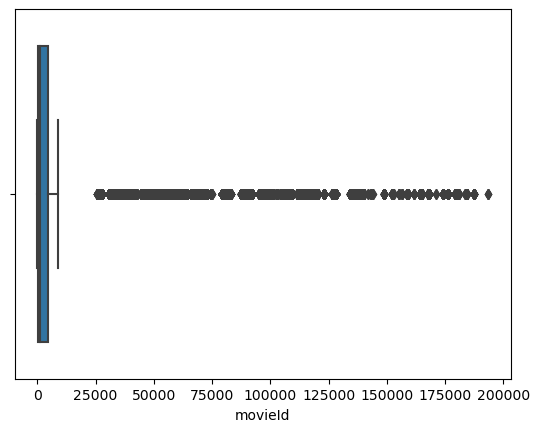

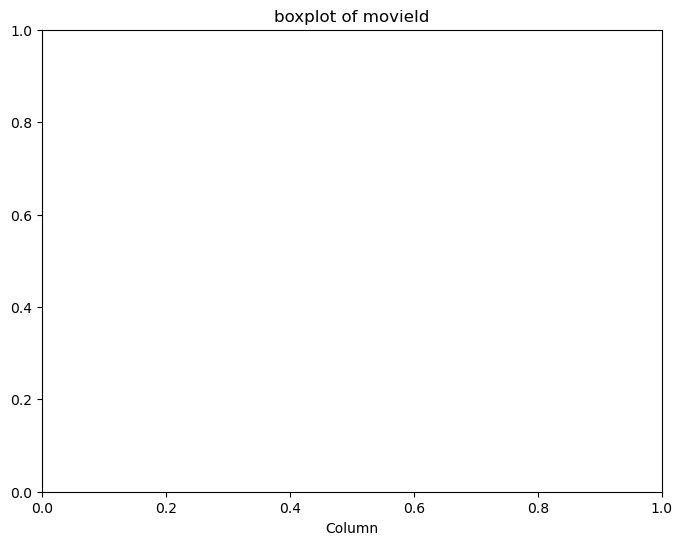

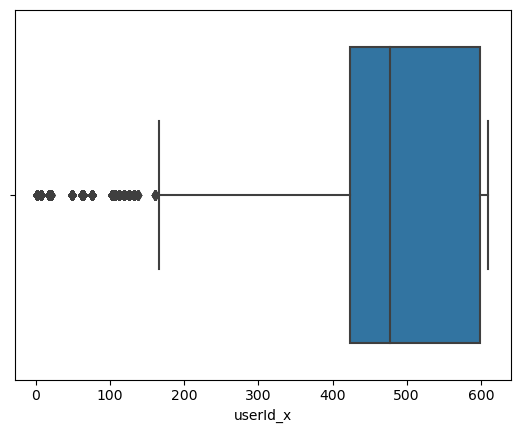

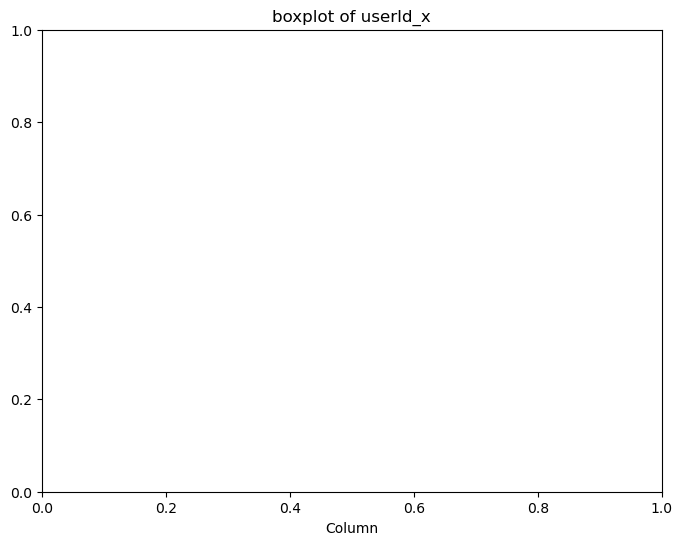

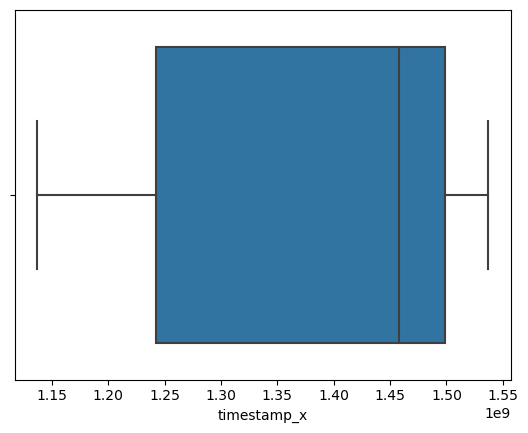

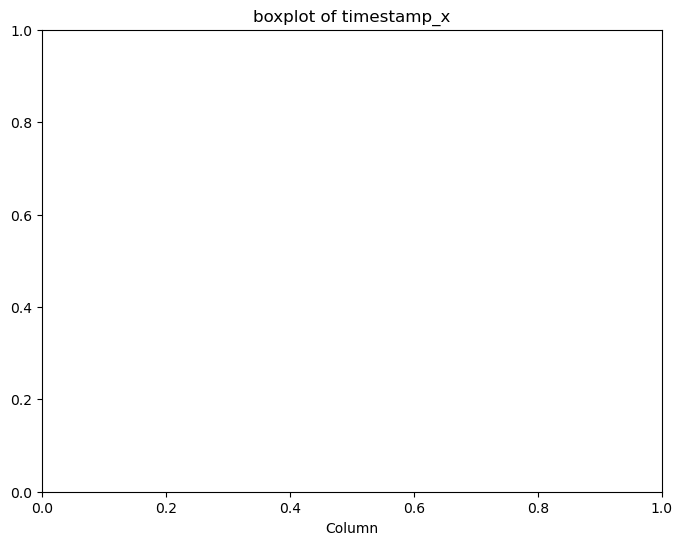

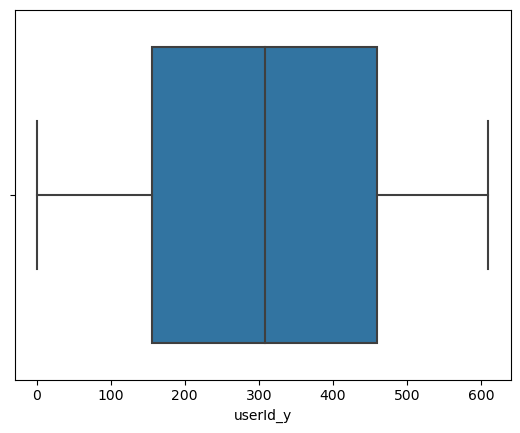

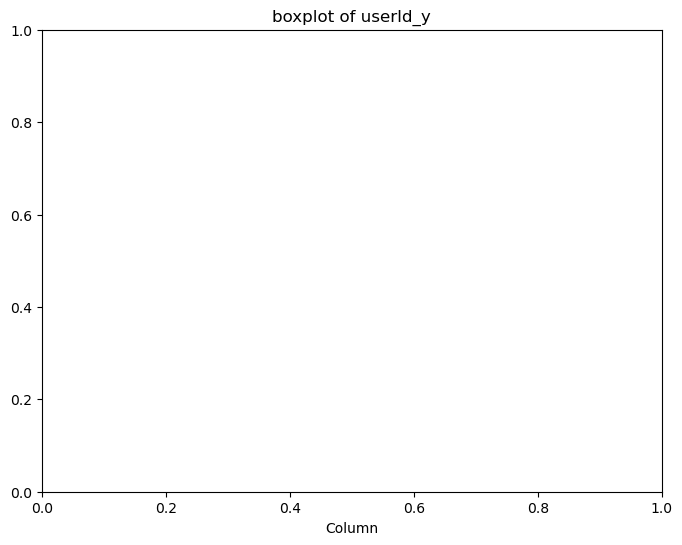

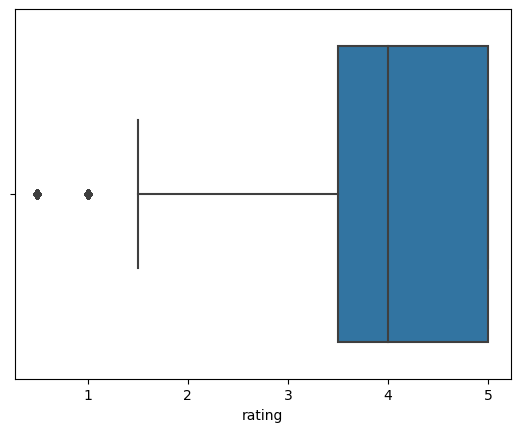

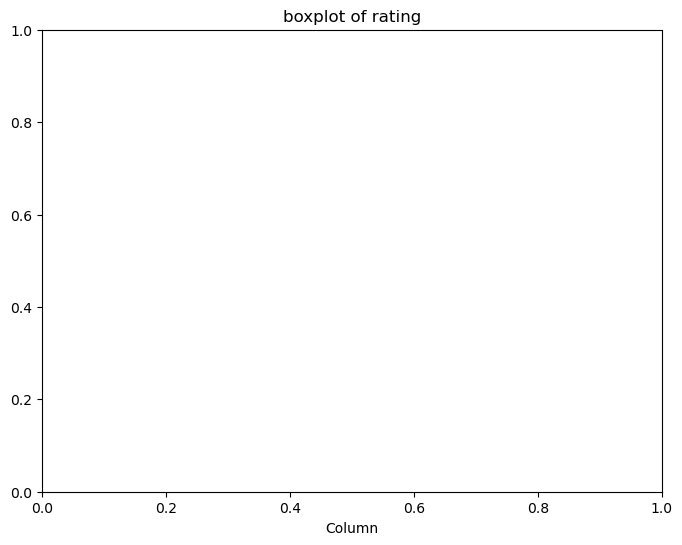

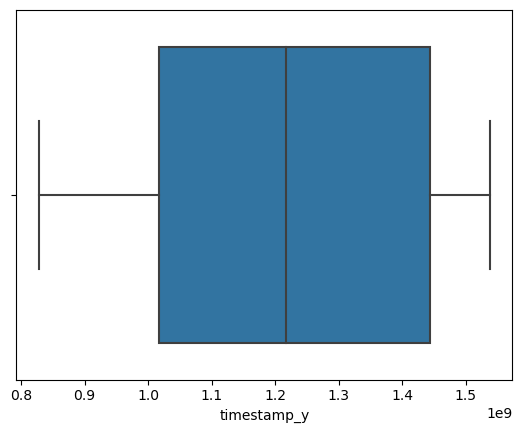

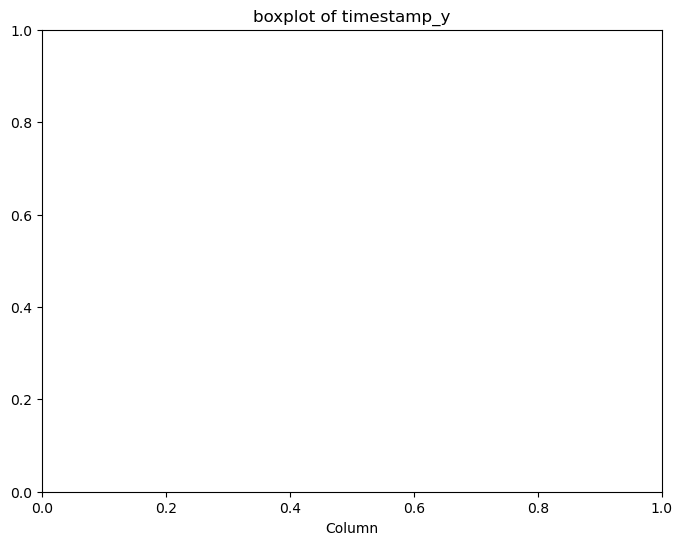

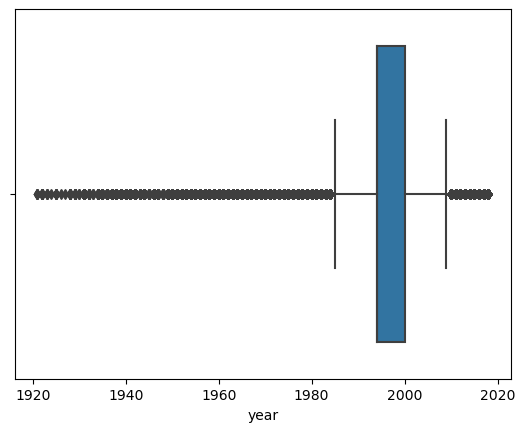

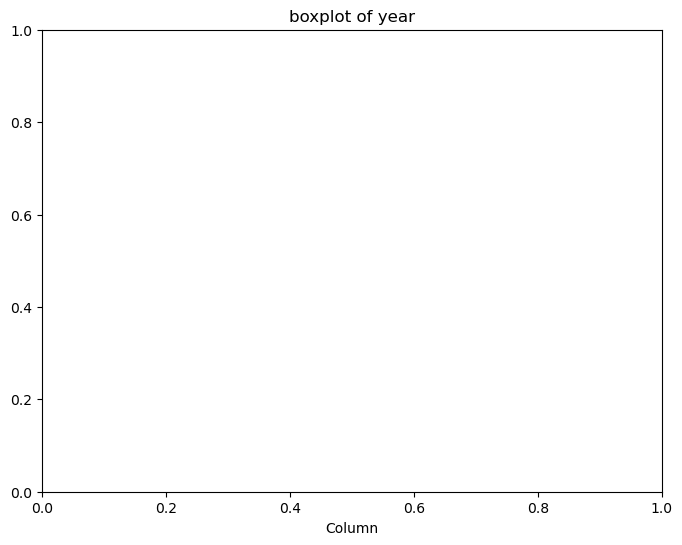

In [16]:
numeric_columns = merged_df.select_dtypes(include="number").columns
for col in numeric_columns:
    sns.boxplot(x=merged_df[col])
    plt.figure(figsize=(8,6))
    plt.xlabel('Column')
    plt.title(f'boxplot of {col}')
    plt.show()

# Explarotary Data Analysis

### Univariate Analysis

In [17]:
# checking summary stats for the dataset
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,233213.0,1.232000e+04,2.824392e+04,1.000000e+00,2.960000e+02,1.198000e+03,4.638000e+03,1.935650e+05
userId_x,233213.0,4.706836e+02,1.533296e+02,2.000000e+00,4.240000e+02,4.770000e+02,5.990000e+02,6.100000e+02
timestamp_x,233213.0,1.384774e+09,1.534621e+08,1.137179e+09,1.242494e+09,1.457901e+09,1.498457e+09,1.537099e+09
userId_y,233213.0,3.096882e+02,1.782064e+02,1.000000e+00,1.560000e+02,3.090000e+02,4.600000e+02,6.100000e+02
rating,233213.0,3.966535e+00,9.686373e-01,5.000000e-01,3.500000e+00,4.000000e+00,5.000000e+00,5.000000e+00
timestamp_y,233213.0,1.213524e+09,2.250448e+08,8.281246e+08,1.017365e+09,1.217325e+09,1.443201e+09,1.537799e+09
year,233210.0,1.994435e+03,1.171456e+01,1.921000e+03,1.994000e+03,1.994000e+03,2.000000e+03,2.018000e+03


In [18]:
# checking values in tag column
merged_df['tag'].value_counts()

tag
sci-fi               2527
thought-provoking    2487
twist ending         2434
atmospheric          2227
dark comedy          2056
                     ... 
Cole Porter             1
deafness                1
convent                 1
Anne Boleyn             1
remaster                1
Name: count, Length: 1584, dtype: int64

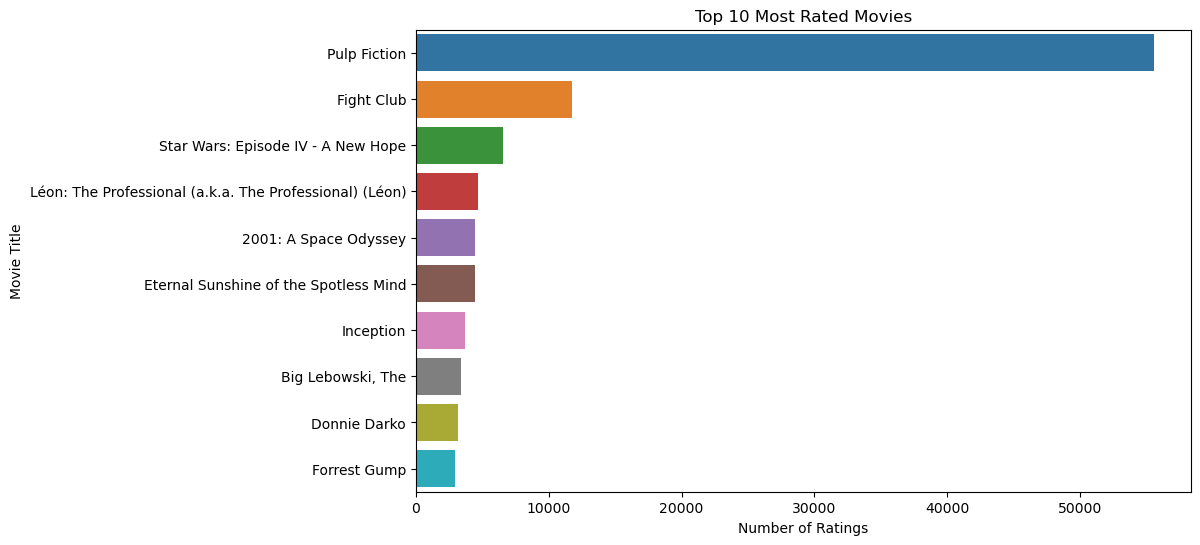

In [19]:
# Count the number of ratings for each movie
movie_ratings = merged_df['title'].value_counts().head(10)

# Plotting the top 10 most rated movies
plt.figure(figsize=(10, 6))
sns.barplot(x=movie_ratings.values, y=movie_ratings.index)
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Most Rated Movies')
plt.show()


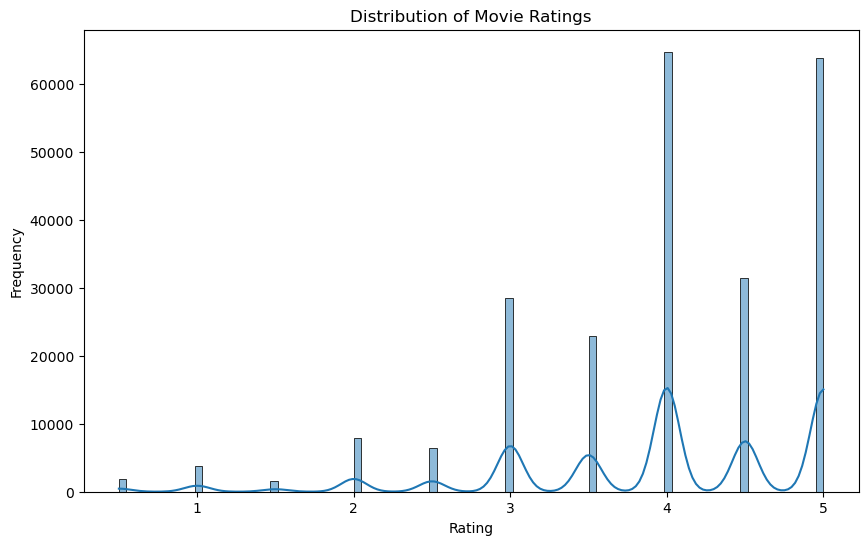

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['rating'], kde=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()

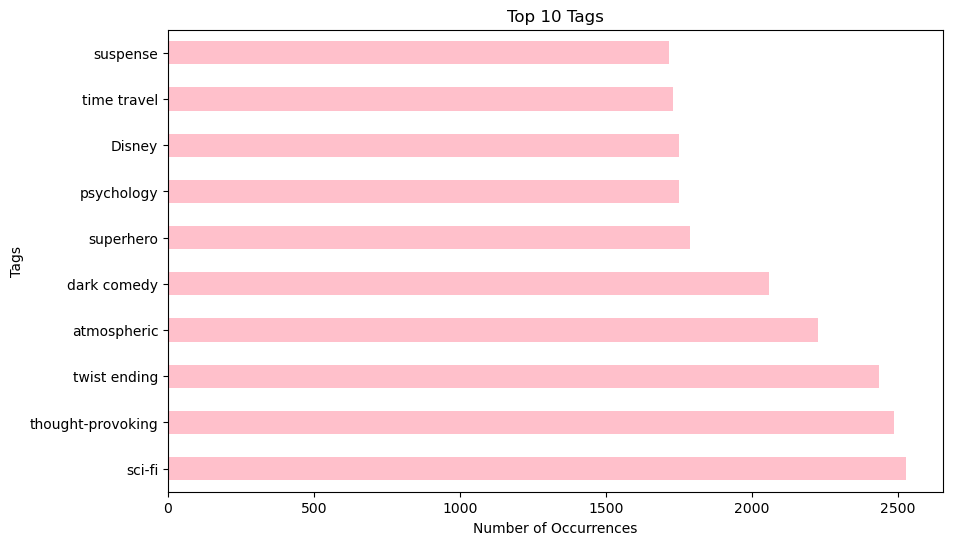

In [24]:
# Plot a bar chart for the top tags
tag_counts = merged_df['tag'].value_counts()
top_tags = tag_counts.head(10)

plt.figure(figsize=(10, 6))
top_tags.plot(kind='barh', color='pink')
plt.title('Top 10 Tags')
plt.xlabel('Number of Occurrences')
plt.ylabel('Tags')
plt.show()

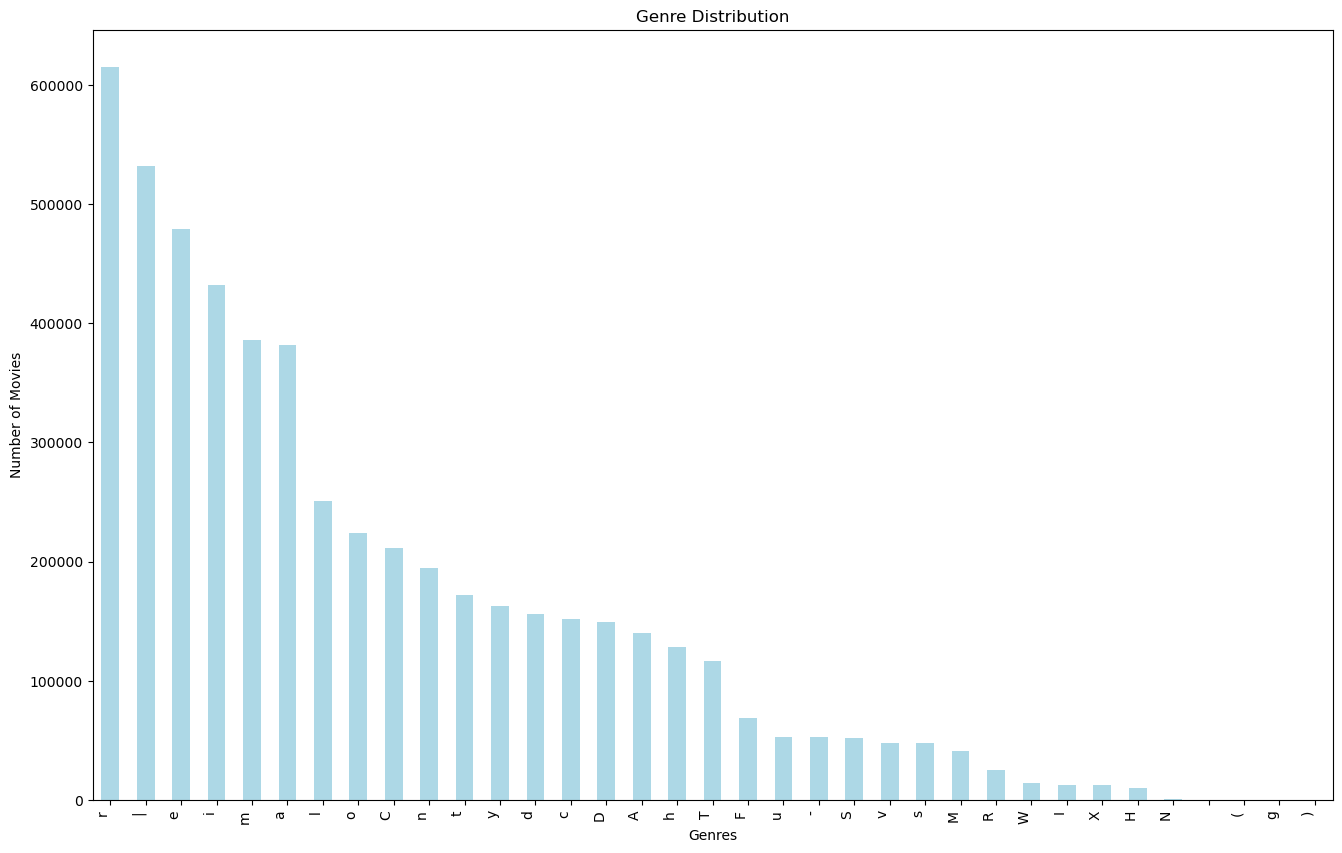

In [26]:
# Plot a bar chart for genre distribution
# Flatten the 'genres' lists
all_genres = [genre for genres_list in merged_df['genres'] for genre in genres_list]

genre_counts = pd.Series(all_genres).value_counts()

# plotting the distribution
plt.figure(figsize=(16, 10))
genre_counts.plot(kind='bar', color='lightblue')
plt.title('Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90, ha='right')
plt.show()

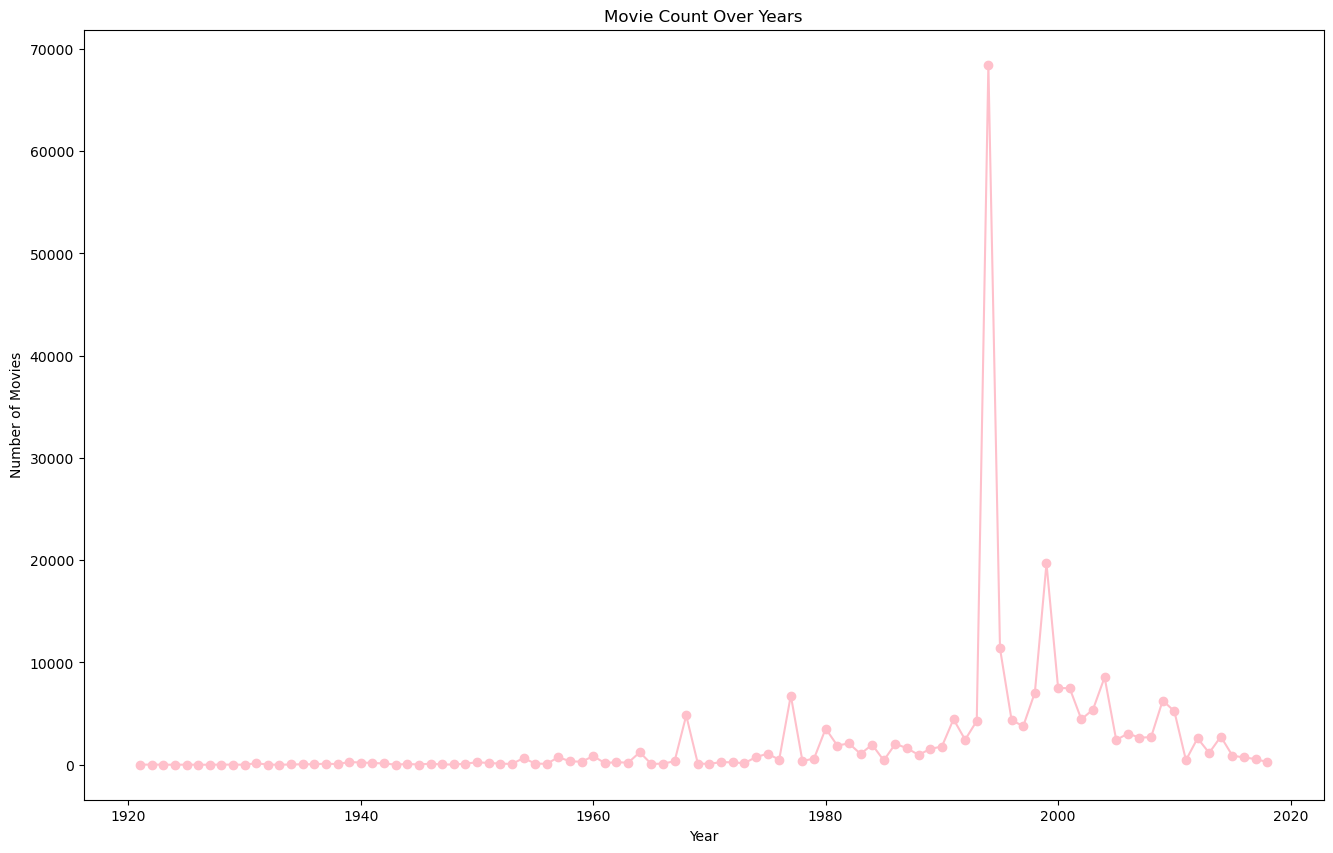

In [27]:
# Plot a line chart for movie count over the years
movie_count_per_year = merged_df['year'].value_counts().sort_index()

plt.figure(figsize=(16, 10))
movie_count_per_year.plot(kind='line', marker='o', color='pink')
plt.title('Movie Count Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

In [28]:
v_rate = dict(merged_df['rating'].value_counts())

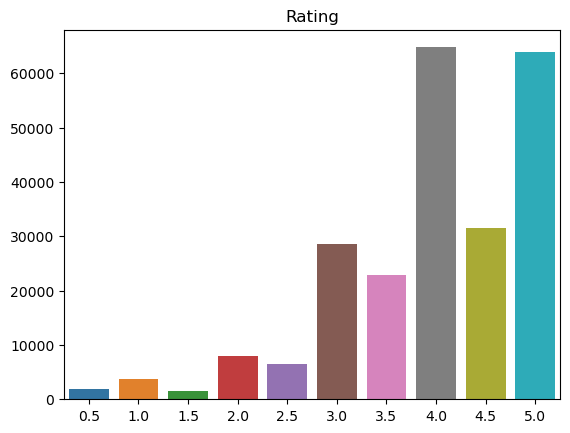

<Figure size 1400x800 with 0 Axes>

In [29]:
plt.title('Rating')
sns.barplot(data=merged_df, x= list(v_rate.keys()),y=list(v_rate.values()))
plt.figure(figsize=(14, 8))
plt.show()

In [30]:
# top_10_views = merged_df['title'].value_counts().head(10)
# plt.figure(figsize=(12, 7))
# sns.barplot(top_10_views.index, top_10_views.values)
# plt.title('Top 10 most viewed movies')
# plt.xlabel('Top 10 most viewed Movie')
# plt.xticks(rotation=90)
# plt.ylabel('Count')
# plt.show()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1200x700 with 0 Axes>

# Bivariate Analysis

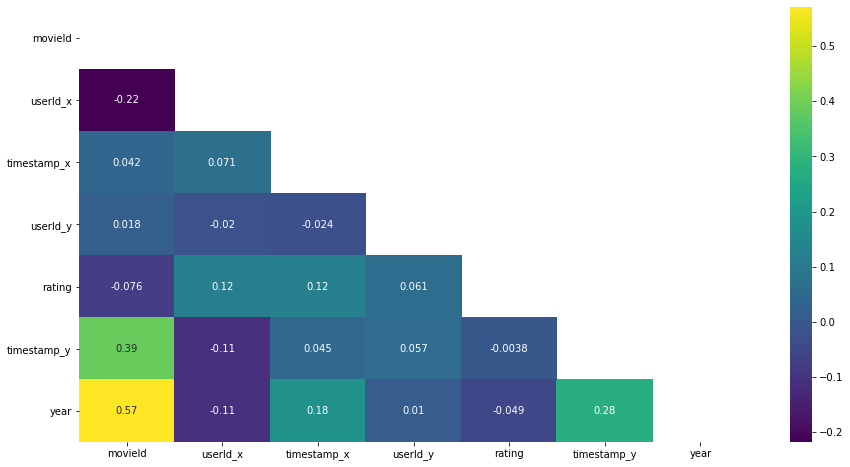

In [ ]:
#plot correlation
plt.figure(figsize=(15, 8))
# Create a mask to display only the upper half of the matrix
mask = np.triu(merged_df.corr())
sns.heatmap(merged_df.corr(), annot=True, cmap='viridis', mask=mask)
plt.show()

## Modelling

In [31]:
# Building Recommendation System (Collaborative Filtering using Surprise library)
# Load data for Surprise library
reader = Reader()
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

# Use SVD algorithm
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Train the model on the entire dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8748  0.8681  0.8710  0.8813  0.8676  0.8726  0.0051  
MAE (testset)     0.6707  0.6672  0.6705  0.6761  0.6670  0.6703  0.0033  
Fit time          3.64    4.46    4.49    4.54    3.98    4.22    0.35    
Test time         0.63    0.50    1.17    0.64    0.35    0.66    0.28    


In [34]:
# Step 6: Make recommendations for a specific user
user_id = 257
user_movies = ratings_data[ratings_data['userId'] == user_id]['movieId']
unrated_movies = movies_data[~movies_data['movieId'].isin(user_movies)]['movieId']

# Generate predictions for unrated movies
user_predictions = [(movie, svd.predict(user_id, movie).est) for movie in unrated_movies]

# Sort predictions by estimated rating
sorted_predictions = sorted(user_predictions, key=lambda x: x[1], reverse=True)

In [35]:
# Display top 5 movie recommendations
top_recommendations = sorted_predictions[:5]
print("Top 5 Movie Recommendations:")
for movie_id, estimated_rating in top_recommendations:
    movie_title = movies_data[movies_data['movieId'] == movie_id]['title'].values[0]
    print(f"Movie: {movie_title}, Estimated Rating: {estimated_rating}")

Top 5 Movie Recommendations:
Movie: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), Estimated Rating: 4.0621237338209175
Movie: Beautiful Mind, A (2001), Estimated Rating: 4.021109805031752
Movie: Lawrence of Arabia (1962), Estimated Rating: 4.0113743685012615
Movie: Thank You for Smoking (2006), Estimated Rating: 3.997179451766266
Movie: Casablanca (1942), Estimated Rating: 3.9808577667330294
